<a href="https://colab.research.google.com/github/prtlobo/Coursera_Capstone/blob/master/MTR_Clustering_based_on_Foursquare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTR Network Clustering Based on Foursquare Data

---

## Introduction:

This project is an exploration into how to cluster a city's subway network based on a certain set of data. The test case was based on the [Hong Kong MTR network](http://www.mtr.com.hk/archive/en/services/routemap.pdf)  and the data used was based on the Foursquare location data. The resulting clusters may be interesting for the following people:
*  Those living in HK or tourists asking themselves which area they want to explore and if the areas are similar or not
*   The MTR corporation in terms of marketing their stations, pricing, zone grouping, estimating the types of people going through the stations, the station amenities/services, etc.
* Other data scientists that want to further explore the clustering by including other different types of data.

This is only an exploration based on Foursquare data, and the clustering can be further refined by including other data (such as population density, housing prices, etc.) depending on the end goal of the exploration.

## Data

The data collection mostly contained 3 sources:
*  [Overpass Turbo ](https://overpass-turbo.eu/)to export the Geojson files to get the coordinates of the stations and their routes(for visualization purposes). It is a web version of the overpass API which pulls data from openstreetmap.
*   Wikipedia to cross reference the station names and to be a backup in case other data collection methods did not work.
* The Foursquare API to collect venue data surrounding each station.



The first attempt at collecting station coordinates was using reverse geocoding based on [Geopy (Nominatim)](https://geopy.readthedocs.io/en/stable/). However, the resulting coordinates were not very accurate for some of the stations. In the end, the [overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) was used to pull data from openstreetmap which included the stations and their routes. Some time was taken to learn the Overpass query language (nodes, ways, relations), and in using the [Overpy](https://pypi.org/project/overpy/) module. The overpy module was not used in the end as the resulting data was not easy to manipulate and was hard to visualize if the query was successful. In the end Overpass turbo was used as one can run a query and see the resulting information. Then the query can be exported as a geojson file.

#### Overpass Turbo Queries used for those who are interested:

In [ ]:
# Don not run, just to copy into overpass turbo
# This query was to get the station routes for visualization
[out:json][timeout:25];

area["ISO3166-1"="HK"]->.boundaryarea;
(
rel(area.boundaryarea)["route"="subway"];
);
out body;
>;
out skel qt;

# This query was to get the station stops

[out:json][timeout:25];
area["ISO3166-1"="HK"]->.boundaryarea;
(
node(area.boundaryarea)["railway"="stop"];
);
out body;
>;
out skel qt;

### Gathering MTR Station Coordinates and Routes

In [ ]:
#Importing all necessary modules for this project
import numpy as np 
import pandas as pd
!pip install geopandas
import geopandas as gpd
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
! pip install folium==0.6.0
import folium
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import widgets
from google.colab import output

In [ ]:
#Used Overpass Turbo to output a Geojson file and then saved it on my Github repo
#This file is for generating the MTR routes
github='https://raw.githubusercontent.com/prtlobo/Coursera_Capstone/master/MTR.geojson'
#Then used Geopandas to read the geojson file
mtrroutegeo=gpd.read_file(github)
#This file is for the stations
github2='https://raw.githubusercontent.com/prtlobo/Coursera_Capstone/master/MTR%20stops.geojson'
mtrstationgeo=gpd.read_file(github2)
#filter just the routes and not the stops
routes=mtrroutegeo[mtrroutegeo['id'].str.contains('relation')]
#remove monorail, light rail, ocean park stops, and unofficially opened stations
mtrstationgeo=mtrstationgeo[mtrstationgeo['monorail'] != 'yes']
mtrstationgeo=mtrstationgeo[mtrstationgeo['light_rail'] != 'yes']
mtrstationgeo=mtrstationgeo[mtrstationgeo['name:en'] != 'Summit']
mtrstationgeo=mtrstationgeo[mtrstationgeo['name:en'] != 'Waterfront']
mtrstationgeo=mtrstationgeo[mtrstationgeo['note'] != 'station to be added at opening']
mtrstationgeo=mtrstationgeo.drop_duplicates('name:en').reset_index(drop=True)
#Create new normal dataframe from geodataframe
mtrstationgeo['Latitude']=mtrstationgeo['geometry'].y
mtrstationgeo['Longitude']=mtrstationgeo['geometry'].x
stations=pd.DataFrame(mtrstationgeo[['name:en','Latitude','Longitude']].copy())
stations=stations.rename(columns={'name:en':'Station'})
stations.head(1)

Station   Latitude   Longitude
0  Tsing Yi  22.358341  114.107421

Extracting data from wikipedia for reference

In [ ]:
#Extract table(s) from wikipedia
wiki='https://en.wikipedia.org/wiki/List_of_MTR_stations'
site=requests.get(wiki).text
wikiscrape=pd.read_html(site,flavor='bs4')
linecolors=['#53B7E8','#00AB4E','#ED1D24','#007DC5','#F7943E','#00888A','#7D499D','#A3238F','#923011','#F173AC','#BAC429']
lines=['East Rail line','Kwun Tong line','Tsuen Wan line','Island line','Tung Chung line','Airport Express','Tseung Kwan O line','West Rail line','Tuen Ma line Phase 1','Disneyland Resort line','South Island line']

#Add MTR line name and color before concat
for i in range(0,11):
    temp_df=wikiscrape[i]
    temp_df.insert(2,'Line', lines[i])
    temp_df.insert(7, 'Line Color', linecolors[i])
#Cleaning up some stations names
mtr=pd.concat(wikiscrape[0:11])
mtr.drop(['Livery','Code','Photo','Connections','Opened','Notes','District'], axis=1,inplace=True)
mtr.reset_index(drop=True,inplace=True)
mtr.iloc[6,0]='University'
mtr.iloc[12,0]='Mong Kok East'
mtr.iloc[13,0]='Hung Hom'
mtr.iloc[16,0]='Yau Ma Tei'
mtr.iloc[17,0]='Mong Kok'
mtr.iloc[36,0]='Mei Foo'
mtr.iloc[41,0]='Mong Kok'
mtr.iloc[42,0]='Yau Ma Tei'
mtr.iloc[46,0]='Central'
mtr.iloc[72,0]='AsiaWorld-Expo'
mtr=mtr.rename(columns={'Name':'Station'})
mtr.drop_duplicates('Station',inplace=True)
mtr.reset_index(drop=True)
mtr.head()

Station            Line Line Color
0        Lo Wu  East Rail line    #53B7E8
1  Lok Ma Chau  East Rail line    #53B7E8
2  Sheung Shui  East Rail line    #53B7E8
3      Fanling  East Rail line    #53B7E8
4       Tai Wo  East Rail line    #53B7E8

In [ ]:
#Merge the Wiki table and coordinates from geopandas
mtr_merged=pd.merge(mtr, stations, on='Station', how='left')
#The "South Horizons" station was missing so will need to input it
mtr_merged.loc[mtr_merged['Station']=='South Horizons',['Latitude','Longitude']]=[22.2425,114.1491]
mtr_merged.head()

Station            Line Line Color   Latitude   Longitude
0        Lo Wu  East Rail line    #53B7E8  22.528200  114.113140
1  Lok Ma Chau  East Rail line    #53B7E8  22.514448  114.065791
2  Sheung Shui  East Rail line    #53B7E8  22.501124  114.128050
3      Fanling  East Rail line    #53B7E8  22.492042  114.138666
4       Tai Wo  East Rail line    #53B7E8  22.450966  114.161201

In [ ]:
# check if the number of stations is 95
len(mtr_merged)

95

### Map of MTR stations and Routes

Have Checkboxes to select MTR routes, Stations, and stations with the search area to be passed to Foursquare

In [ ]:
#plot Geojson Routes, Stations and Foursquare API radius
map_hk = folium.Map(tiles=None, location=[22.3193,114.1694])

folium.TileLayer('Cartodb dark_matter', overlay=False, control=False).add_to(map_hk)

#Plot MTR Routes
routefeaturegroup=folium.FeatureGroup('MTR Routes', show=True)
for i in range(0,len(routes)):
  geom=routes.iloc[[i]]
  color=routes.loc[i,'colour']
  gjson = folium.features.GeoJson(geom, style_function= lambda feature, color=color: {'color':color, 'weight':1})                                                                     
  routefeaturegroup.add_child(gjson)
#Plot Stations
stationfeaturegroup=folium.FeatureGroup('MTR stations', show=True)
for lat, lng, station, clr in zip(mtr_merged['Latitude'],mtr_merged['Longitude'], mtr_merged['Station'], mtr_merged['Line Color']):
    label = '{} Station'.format(station)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        color=clr,
        fill=True,
        fill_color=clr,
        fill_opacity=1,
        ).add_to(stationfeaturegroup)

#plot stations with API radius
foursquarefeaturegroup=folium.FeatureGroup(name='FourSquare API Radius',show=False)
for lat, lng, clr in zip(mtr_merged['Latitude'],mtr_merged['Longitude'], mtr_merged['Line Color']):
  folium.Circle(
    radius=500,
    location=[lat, lng],
    color=clr,
    fill=True,
    fill_color=clr,
    fill_opacity=0.4).add_to(foursquarefeaturegroup)

routefeaturegroup.add_to(map_hk)
stationfeaturegroup.add_to(map_hk)
foursquarefeaturegroup.add_to(map_hk)
folium.LayerControl(collapsed=False).add_to(map_hk)
folium.FitBounds(stationfeaturegroup.get_bounds()).add_to(map_hk)
map_hk

### Foursquare API

The [Foursquare](https://developer.foursquare.com/) API was used to collect data. One would need to sign up for their services and pass credentials in the API call. The explore venues option as called which will search around a coordinate for a given radius. In this case the MTR station coordinates were passed and the venues in a 500m radius were collected. 

In [ ]:
#Setting Foursquare API information
#Credentials will be removed so will need to sign up for it
CLIENT_ID = 'X'
CLIENT_SECRET = 'X'
ACCESS_TOKEN = 'X'
VERSION = '20180605'
LIMIT = 100
radius = 500

#function to get venues for each  Station
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
#run the function to get foursquare data
mtr_venues = getNearbyVenues(names=mtr_merged['Station'],
                                   latitudes=mtr_merged['Latitude'],
                                   longitudes=mtr_merged['Longitude']
                                  )
mtr_venues.head()

Station  Station Latitude  ...  Venue Longitude        Venue Category
0   Lo Wu           22.5282  ...       114.113027           Coffee Shop
1   Lo Wu           22.5282  ...       114.113630  Fast Food Restaurant
2   Lo Wu           22.5282  ...       114.113456       Border Crossing
3   Lo Wu           22.5282  ...       114.113192              Platform
4   Lo Wu           22.5282  ...       114.113241    Chinese Restaurant

[5 rows x 7 columns]

In [ ]:
#check if Foursquare returned any missing/empty results
mtr_merged['Missing']=mtr_merged['Station'].isin(mtr_venues['Station'])
len(mtr_merged[mtr_merged['Missing']==False])

0

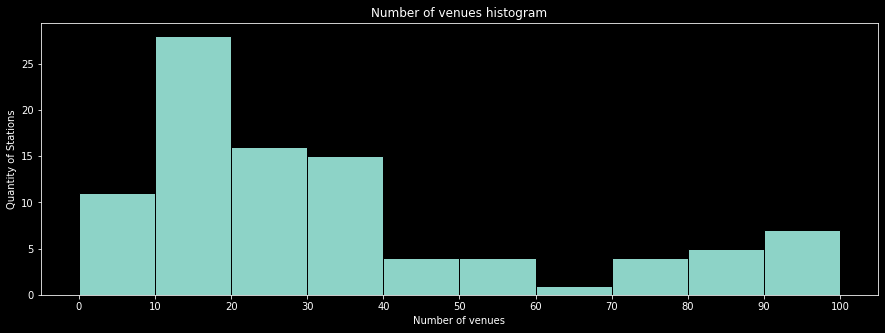

In [ ]:
#get some information on the number of responses
plt.style.use('dark_background')
mtr_venues['Station'].value_counts().plot(kind='hist',figsize=(15,5), bins=range(0,110,10), ec='black')
plt.xticks(ticks=range(0,110,10))
plt.title('Number of venues histogram')
plt.xlabel('Number of venues')
plt.ylabel('Quantity of Stations')
plt.show()

In [ ]:
#Find the number of stations that got less than 10 venues
num_top_venues = 10
mtr_venues_low=mtr_venues['Station'].value_counts()[mtr_venues['Station'].value_counts()<num_top_venues].to_frame()
len(mtr_venues_low)

11

It can be shown above the majority of stations got sufficient number of venues. However, there is some stations that received less than 10 venues. In this case, there are some solutions to this by either removing those stations entirely from the algorithm, or replacing the last few venues with the mean venues, or randomly selecting venues.

In [ ]:
#create one hot for each of the venue catagories then create new dataframe with normalised values
mtr_onehot=pd.get_dummies(mtr_venues[['Venue Category']], prefix="", prefix_sep="")
mtr_onehot.insert(0,'Station', mtr_venues['Station'])
mtr_grouped = mtr_onehot.groupby('Station').mean().reset_index()
mtr_grouped.head()

Station  ATM  ...       Zoo  Zoo Exhibit
0       Admiralty  0.0  ...  0.012346          0.0
1         Airport  0.0  ...  0.000000          0.0
2  AsiaWorld-Expo  0.0  ...  0.000000          0.0
3          Austin  0.0  ...  0.000000          0.0
4    Causeway Bay  0.0  ...  0.000000          0.0

[5 rows x 283 columns]

In [ ]:
#Get top N venues for all the stations (total dataset)
mtr_onehottotal=pd.get_dummies(mtr_venues[['Venue Category']], prefix="", prefix_sep="")
mtr_toptotal=mtr_onehottotal.mean().sort_values(ascending=False).head(num_top_venues)
mtr_toptotal

Chinese Restaurant      0.054046
Coffee Shop             0.049771
Café                    0.039695
Fast Food Restaurant    0.039389
Japanese Restaurant     0.035115
Hotel                   0.029924
Cha Chaan Teng          0.027786
Cantonese Restaurant    0.027786
Noodle House            0.027176
Shopping Mall           0.025344
dtype: float64

Originally, the function, "return_most_common_venues" would sort the normalized values first then sort the venue alphabetically. If the station had less than 10 venues, semi random venues would be allocated depending on the alphabetical ordering. This had some implications about how the algorithm may cluster this station depending if it was very similar or different to the others. The code was tweaked to insert the top 10 "mean" venues.

In [ ]:
#Function to get the top N venues for each station
def return_most_common_venues(row, num_top_venues):
  row_categories = row.iloc[1:]
  row_categories_top=row_categories.sort_values(ascending=False).head(num_top_venues)
  #If any of the top n venues has zero (normalized value), then replace the missing venues with the respective top venue of the total dataset
  if any(row_categories_top==0):
    temp=row_categories_top.index[row_categories_top!=0]
    temp=temp.append(mtr_toptotal.index[row_categories_top==0])
    row_categories_top=row_categories_top.reindex(temp)
    row_categories_top.fillna(0,inplace=True)
  row_categories_top=row_categories_top.index.values[0:num_top_venues]
  return row_categories_top

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

mtr_venues_sorted = pd.DataFrame(columns=columns)
mtr_venues_sorted['Station'] = mtr_grouped['Station']

for ind in np.arange(mtr_grouped.shape[0]):
    mtr_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mtr_grouped.iloc[ind, :], num_top_venues)

mtr_venues_sorted.head()

Station  ... 10th Most Common Venue
0       Admiralty  ...               Tea Room
1         Airport  ...           Cocktail Bar
2  AsiaWorld-Expo  ...               Bus Stop
3          Austin  ...     Dim Sum Restaurant
4    Causeway Bay  ...              Gift Shop

[5 rows x 11 columns]

The resulting table shows for each station, the top 10 most common types of venues.

## Methodology:

After getting the top N most common venues for each station, the machine learning algorithm, K means clustering was used to cluster the stations based on the venues. The main hyper parameter that will need to be optimized is k or the number of clusters that the algorithm will attempt to make. There were two different k means models based on two different values for k:
*   One path was to measure the silhouette score for a range of k, and chose the k with the best score.
*   The other path was to use the number of MTR train lines as the k. In this case, k=11. This is an experiment in what a different MTR network would look like based on this data.




### Optimize and Create Kmeans clustering models

In [ ]:
#finding best k number for cluster using silouhette score
mtr_grouped_clustering = mtr_grouped.drop('Station', 1)

sil = []
kmax = 20
#Run algorithm looping through k 
for k in range(2, kmax+1):
  kmeanstest = KMeans(n_clusters=k).fit(mtr_grouped_clustering)
  labels = kmeanstest.labels_
  sil.append(silhouette_score(mtr_grouped_clustering, labels, metric = 'euclidean'))

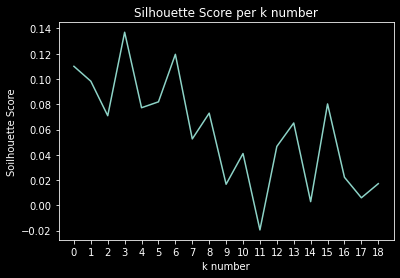

In [ ]:
#plot graph of silhouette score
plt.style.use('dark_background')
plt.plot(sil)
plt.xticks(range(0,19))
plt.title('Silhouette Score per k number')
plt.xlabel('k number')
plt.ylabel('Soilhouette Score')
plt.show()

Interestingly, sometimes when the Foursquare API function is called, different data is collected, and the k best sometimes vary for different data runs. For past iterations there was k= 2, 5, and 6 and may be different again. Just a note if this code was to be run at a different time, as the k best may be different.

### Creating 2 models: 


*   Using best k according to silhouette Score
*   Using the same number of existing MTR lines

Interestingly, according to the silhouette score, clustering by the number of MTR lines (11) sometimes yielded the lowest score. But it will be attempted anyways for experimentation and visualization purposes.


In [ ]:
#choose k with highest silhouhette score after k=1
kbest=sil.index(max(sil[1:20]))
kmeanbest = KMeans(n_clusters=kbest, random_state=0).fit(mtr_grouped_clustering)
#choose k by number of MTR lines
klines=len(lines)
kmeanlines = KMeans(n_clusters=klines, random_state=0).fit(mtr_grouped_clustering)

print('The best K for clustering is: {}'.format(kbest))
print('The number of MTR lines is: {}'.format(klines))

The best K for clustering is: 3
The number of MTR lines is: 11


In [ ]:
#Combine cluster label results with station data and Foursquare API data
mtr_venues_kmean=mtr_venues_sorted
#mtr_results.drop('Cluster Labels (kbest)', axis=1, inplace=True)
#mtr_results.drop('Cluster Labels (klines)', axis=1, inplace=True)
mtr_venues_kmean.insert(0, 'Cluster Labels (kbest)', kmeanbest.labels_)
mtr_venues_kmean.insert(1, 'Cluster Labels (klines)', kmeanlines.labels_)
mtr_results=mtr_merged
mtr_results.drop('Missing', axis=1, inplace=True)
mtr_results = mtr_results.join(mtr_venues_kmean.set_index('Station'), on='Station')
mtr_results.head()

Station            Line  ... 9th Most Common Venue  10th Most Common Venue
0        Lo Wu  East Rail line  ...       Border Crossing                  Bakery
1  Lok Ma Chau  East Rail line  ...          Noodle House           Shopping Mall
2  Sheung Shui  East Rail line  ...         Shopping Mall              Steakhouse
3      Fanling  East Rail line  ...           Coffee Shop        Sushi Restaurant
4       Tai Wo  East Rail line  ...    Athletics & Sports                Wine Bar

[5 rows x 17 columns]

## Results:

### Map of Clusters

Ability to toggle between K best and K based on MTR lines (11)

In [ ]:
#plot map with toggle between K best and K lines
map_clusters = folium.Map(tiles=None, location=[22.3193,114.1694])

folium.TileLayer('Cartodb dark_matter', overlay=False, control=False).add_to(map_clusters)

#Plot cluster points for K best
clusterkbest=folium.FeatureGroup('K Best Cluster', overlay=False)
for lat, lng, stn, cluster in zip(mtr_results['Latitude'], mtr_results['Longitude'], mtr_results['Station'], mtr_results['Cluster Labels (kbest)']):
    label = str(stn) + ' Cluster ' + str(cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        #Use MTR lines color
        color=linecolors[cluster],
        fill=True,
        fill_color=linecolors[cluster],
        fill_opacity=1).add_to(clusterkbest)    
#Plot cluster points for K lines
clusterkline=folium.FeatureGroup('MTR Line Cluster', overlay=False)
for lat, lng, stn, cluster in zip(mtr_results['Latitude'], mtr_results['Longitude'], mtr_results['Station'], mtr_results['Cluster Labels (klines)']):
    label = str(stn) + ' Cluster ' + str(cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        tooltip=label,
        #Use MTR lines color
        color=linecolors[cluster],
        fill=True,
        fill_color=linecolors[cluster],
        fill_opacity=1).add_to(clusterkline)
clusterkbest.add_to(map_clusters)
clusterkline.add_to(map_clusters)
folium.LayerControl(collapsed=False).add_to(map_clusters)
folium.FitBounds(clusterkbest.get_bounds()).add_to(map_clusters)
map_clusters


## Discussion

### Charts for list of stations per cluster

Dataframes were generated for each model showing the list of stations per cluster. This one below is for K best:

In [ ]:
# Create dataframe showing each cluster and the stations within them
#This is for K best
def colorlow(val):
  color = 'red' if val in mtr_venues_low.index else 'black'
  return 'color: %s' % color
mtr_station_cluster=mtr_results[['Station', 'Cluster Labels (kbest)','Cluster Labels (klines)']]
mtrkbestcluster=mtr_station_cluster[['Station','Cluster Labels (kbest)']]
df_kbest=mtrkbestcluster.pivot(columns='Cluster Labels (kbest)', values='Station')
df_kbest.columns.name = None
#Sort values alphabetically ignoring other columns
for i, column in enumerate(df_kbest):
  df_kbest[column]=df_kbest[column].sort_values().values
  df_kbest.rename(columns={column:'Cluster '+ str(column)}, inplace=True)
df_kbest.dropna(axis=0, how='all', subset=df_kbest.columns, inplace=True)
#Replace NaN with empty string for cleaner output
df_kbest.fillna('', inplace=True)
#Highlight stations that had less than 10 venues
#Apologize for the not so pretty output of the dataframe. Seems to be some issues with how Google Colab handles the CSS.
df_kbest= df_kbest.style.applymap(colorlow)
df_kbest

This one is for K lines (11):

In [ ]:
# Create dataframe showing each cluster and the stations within them
#This is for K lines (11)
mtr_station_cluster=mtr_results[['Station', 'Cluster Labels (kbest)','Cluster Labels (klines)']]
mtrklinecluster=mtr_station_cluster[['Station','Cluster Labels (klines)']]
df_kline=mtrklinecluster.pivot(columns='Cluster Labels (klines)', values='Station')
df_kline.columns.name = None
for i, column in enumerate(df_kline):
  df_kline[column]=df_kline[column].sort_values().values
  df_kline.rename(columns={column:'Cluster '+ str(column)}, inplace=True)
df_kline.dropna(axis=0, how='all', subset=df_kline.columns, inplace=True)
df_kline.fillna('', inplace=True)
#Highlight stations that had less than 10 venues
#Apologize for the not so pretty output of the dataframe. Seems to be some issues with how Google Colab handles the CSS.
df_kline=df_kline.style.applymap(colorlow)
df_kline

It is interesting to note how the algorithm, when forced to create the 11 clusters, puts some of the stations with less than 10 venues in their own cluster. There must be some key venues that distinguish those stations from the rest. On that note, below will be some tabbed dataframes showing the resulting venues for filtered for each cluster:

This one is for the K Best clustering:

In [ ]:
#Create sliced dataframes for each cluster
clusterbestlist=list('Cluster '+ str(i) for i in range(kmeanbest.labels_.min(),kmeanbest.labels_.max()+1,))
listofkbest=[]

for i, clstr in enumerate(clusterbestlist):
  df=mtr_results.loc[mtr_results['Cluster Labels (kbest)'] == i, mtr_results.columns[[0] + list(range(7, mtr_results.shape[1]))]]
  listofkbest.append(df)
#Use the tabbar widgit to create tabs for each cluster
tabs = widgets.TabBar(clusterbestlist, location='top')
for i, df in enumerate(listofkbest):
  with tabs.output_to(i):
    display(df)
#Feel free to click on each tab for each cluster below

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ...    10th Most Common Venue
1          Lok Ma Chau  ...             Shopping Mall
4               Tai Wo  ...                  Wine Bar
6           University  ...                  Gym Pool
9              Sha Tin  ...       Japanese Restaurant
10             Tai Wai  ...               Bus Station
11        Kowloon Tong  ...            Cha Chaan Teng
12       Mong Kok East  ...      Hong Kong Restaurant
13            Hung Hom  ...      Cantonese Restaurant
14             Whampoa  ...           Thai Restaurant
15          Ho Man Tin  ...       Dumpling Restaurant
16          Yau Ma Tei  ...        Athletics & Sports
17            Mong Kok  ...          Toy / Game Store
18       Prince Edward  ...                       Bar
20              Lok Fu  ...             Shopping Mall
22        Diamond Hill  ...      Taiwanese Restaurant
25        Ngau Tau Kok  ...        Athletics & Sports
26           Kwun Tong  ...              Noodle House
31          Tai Wo Hau  ...              Burger Joint
36         Lai Chi Kok  ...              Noodle House
38        Sham Shui Po  ...        Italian Restaurant
39              Jordan  ...               Flea Market
40       Tsim Sha Tsui  ...                    Hostel
41           Admiralty  ...                  Tea Room
42             Central  ...          Sushi Restaurant
43        Kennedy Town  ...         French Restaurant
44                 HKU  ...        Athletics & Sports
45        Sai Ying Pun  ...              Dessert Shop
46          Sheung Wan  ...          Ramen Restaurant
47            Wan Chai  ...                       Bar
48        Causeway Bay  ...                 Gift Shop
49             Tin Hau  ...      Cantonese Restaurant
50       Fortress Hill  ...           Thai Restaurant
51         North Point  ...                 Gastropub
52          Quarry Bay  ...      Taiwanese Restaurant
53             Tai Koo  ...                Food Court
54          Sai Wan Ho  ...             Shopping Mall
58          Tung Chung  ...            Clothing Store
60            Tsing Yi  ...          Department Store
62             Olympic  ...      Hong Kong Restaurant
63             Kowloon  ...            Scenic Lookout
64           Hong Kong  ...              Cocktail Bar
65      AsiaWorld-Expo  ...                  Bus Stop
66             Airport  ...              Cocktail Bar
69          LOHAS Park  ...             Shopping Mall
70       Tseung Kwan O  ...            Cha Chaan Teng
71            Tuen Mun  ...                 BBQ Joint
75           Yuen Long  ...           Bubble Tea Shop
77      Tsuen Wan West  ...       Shanghai Restaurant
78              Austin  ...        Dim Sum Restaurant
79  East Tsim Sha Tsui  ...                    Buffet
81          Ma On Shan  ...               Coffee Shop
84            Shek Mun  ...             Shopping Mall
91      South Horizons  ...          Sushi Restaurant
93      Wong Chuk Hang  ...  Mediterranean Restaurant
94          Ocean Park  ...             Shopping Mall

[55 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ...         10th Most Common Venue
0             Lo Wu  ...                         Bakery
2       Sheung Shui  ...                     Steakhouse
3           Fanling  ...               Sushi Restaurant
5     Tai Po Market  ...                  Train Station
7        Racecourse  ...                  Shopping Mall
8            Fo Tan  ...                  Shopping Mall
19     Shek Kip Mei  ...                  Grocery Store
21     Wong Tai Sin  ...                     Astrologer
23        Choi Hung  ...                     Playground
24      Kowloon Bay  ...            Shanghai Restaurant
27          Lam Tin  ...                       Bus Stop
28         Yau Tong  ...                  Shopping Mall
29    Tiu Keng Leng  ...               Sushi Restaurant
30        Tsuen Wan  ...                   Burger Joint
32        Kwai Hing  ...              Convenience Store
33        Kwai Fong  ...                  Grocery Store
34         Lai King  ...                       Bus Stop
35          Mei Foo  ...                  Shopping Mall
37   Cheung Sha Wan  ...             Athletics & Sports
55     Shau Kei Wan  ...                  Grocery Store
56    Heng Fa Chuen  ...                       Tea Room
57         Chai Wan  ...                    Coffee Shop
59        Sunny Bay  ...                  Shopping Mall
61       Nam Cheong  ...                  Shopping Mall
67           Po Lam  ...                   Dessert Shop
68         Hang Hau  ...                 Cha Chaan Teng
72         Siu Hong  ...                  Shopping Mall
73     Tin Shui Wai  ...                  Shopping Mall
74        Long Ping  ...             Chinese Restaurant
76  Kam Sheung Road  ...                  Shopping Mall
80       Wu Kai Sha  ...                          Diner
82          Heng On  ...                  Track Stadium
83    Tai Shui Hang  ...                           Park
85         City One  ...                  Train Station
86      Sha Tin Wai  ...                   Dessert Shop
87  Che Kung Temple  ...                  Shopping Mall
88         Hin Keng  ...                         Tunnel
89          Kai Tak  ...                  Shopping Mall
92         Lei Tung  ...  Paper / Office Supplies Store

[39 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
90  Disneyland Resort  ...          Shopping Mall

[1 rows x 11 columns]

<IPython.core.display.Javascript object>

As shown above, as of writing this notebook, the algorithm has created 3 clusters. Some insights can be made about these clusters:
*   Cluster 0 seems to concentrate on entertainment and some F&B venues. This also represents the types of venues considered in "central" Hong Kong.
*   Cluster 1 seems to concentrate heavily on F&B related venues. It also just happens to relate to venues outside of what is considered "central" Hong Kong.
* Cluster 2 is just one station- The Disneyland resort station. One can see how much different this one is to other stations. However, it is interesting that another station, Ocean Park, is not also clustered together with this station considering they are both amusement parks.



This one is for the K lines clustering:

In [ ]:
#Create sliced dataframes for each cluster
clusterlineslist=list('Cluster '+ str(i) for i in range(kmeanlines.labels_.min(),kmeanlines.labels_.max()+1,))
listofklines=[]

for i, clstr in enumerate(clusterlineslist):
  df=mtr_results.loc[mtr_results['Cluster Labels (klines)'] == i, mtr_results.columns[[0] + list(range(7, mtr_results.shape[1]))]]
  listofklines.append(df)
#Use the tabbar widgit to create tabs for each cluster
tabs = widgets.TabBar(clusterlineslist, location='top')
for i, df in enumerate(listofklines):
  with tabs.output_to(i):
    display(df)
#Feel free to click on each tab for each cluster below

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
1   Lok Ma Chau  ...          Shopping Mall
59    Sunny Bay  ...          Shopping Mall

[2 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
0           Lo Wu  ...                 Bakery
3         Fanling  ...       Sushi Restaurant
15     Ho Man Tin  ...    Dumpling Restaurant
23      Choi Hung  ...             Playground
34       Lai King  ...               Bus Stop
44            HKU  ...     Athletics & Sports
54     Sai Wan Ho  ...          Shopping Mall
55   Shau Kei Wan  ...          Grocery Store
56  Heng Fa Chuen  ...               Tea Room
57       Chai Wan  ...            Coffee Shop
78         Austin  ...     Dim Sum Restaurant
84       Shek Mun  ...          Shopping Mall
86    Sha Tin Wai  ...           Dessert Shop

[13 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
90  Disneyland Resort  ...          Shopping Mall

[1 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
61  Nam Cheong  ...          Shopping Mall

[1 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ...         10th Most Common Venue
2       Sheung Shui  ...                     Steakhouse
5     Tai Po Market  ...                  Train Station
7        Racecourse  ...                  Shopping Mall
10          Tai Wai  ...                    Bus Station
19     Shek Kip Mei  ...                  Grocery Store
21     Wong Tai Sin  ...                     Astrologer
24      Kowloon Bay  ...            Shanghai Restaurant
27          Lam Tin  ...                       Bus Stop
28         Yau Tong  ...                  Shopping Mall
30        Tsuen Wan  ...                   Burger Joint
32        Kwai Hing  ...              Convenience Store
33        Kwai Fong  ...                  Grocery Store
37   Cheung Sha Wan  ...             Athletics & Sports
38     Sham Shui Po  ...             Italian Restaurant
67           Po Lam  ...                   Dessert Shop
68         Hang Hau  ...                 Cha Chaan Teng
74        Long Ping  ...             Chinese Restaurant
80       Wu Kai Sha  ...                          Diner
81       Ma On Shan  ...                    Coffee Shop
82          Heng On  ...                  Track Stadium
83    Tai Shui Hang  ...                           Park
85         City One  ...                  Train Station
87  Che Kung Temple  ...                  Shopping Mall
88         Hin Keng  ...                         Tunnel
89          Kai Tak  ...                  Shopping Mall
92         Lei Tung  ...  Paper / Office Supplies Store

[26 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
94  Ocean Park  ...          Shopping Mall

[1 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
76  Kam Sheung Road  ...          Shopping Mall

[1 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
72      Siu Hong  ...          Shopping Mall
73  Tin Shui Wai  ...          Shopping Mall

[2 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ...    10th Most Common Venue
4               Tai Wo  ...                  Wine Bar
6           University  ...                  Gym Pool
9              Sha Tin  ...       Japanese Restaurant
11        Kowloon Tong  ...            Cha Chaan Teng
12       Mong Kok East  ...      Hong Kong Restaurant
13            Hung Hom  ...      Cantonese Restaurant
14             Whampoa  ...           Thai Restaurant
16          Yau Ma Tei  ...        Athletics & Sports
17            Mong Kok  ...          Toy / Game Store
18       Prince Edward  ...                       Bar
20              Lok Fu  ...             Shopping Mall
22        Diamond Hill  ...      Taiwanese Restaurant
25        Ngau Tau Kok  ...        Athletics & Sports
26           Kwun Tong  ...              Noodle House
29       Tiu Keng Leng  ...          Sushi Restaurant
31          Tai Wo Hau  ...              Burger Joint
35             Mei Foo  ...             Shopping Mall
36         Lai Chi Kok  ...              Noodle House
39              Jordan  ...               Flea Market
40       Tsim Sha Tsui  ...                    Hostel
41           Admiralty  ...                  Tea Room
42             Central  ...          Sushi Restaurant
43        Kennedy Town  ...         French Restaurant
45        Sai Ying Pun  ...              Dessert Shop
46          Sheung Wan  ...          Ramen Restaurant
47            Wan Chai  ...                       Bar
48        Causeway Bay  ...                 Gift Shop
49             Tin Hau  ...      Cantonese Restaurant
50       Fortress Hill  ...           Thai Restaurant
51         North Point  ...                 Gastropub
52          Quarry Bay  ...      Taiwanese Restaurant
53             Tai Koo  ...                Food Court
58          Tung Chung  ...            Clothing Store
60            Tsing Yi  ...          Department Store
62             Olympic  ...      Hong Kong Restaurant
63             Kowloon  ...            Scenic Lookout
64           Hong Kong  ...              Cocktail Bar
65      AsiaWorld-Expo  ...                  Bus Stop
66             Airport  ...              Cocktail Bar
70       Tseung Kwan O  ...            Cha Chaan Teng
71            Tuen Mun  ...                 BBQ Joint
75           Yuen Long  ...           Bubble Tea Shop
77      Tsuen Wan West  ...       Shanghai Restaurant
79  East Tsim Sha Tsui  ...                    Buffet
91      South Horizons  ...          Sushi Restaurant
93      Wong Chuk Hang  ...  Mediterranean Restaurant

[46 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station 1st Most Common Venue  ... 9th Most Common Venue 10th Most Common Venue
8  Fo Tan  Fast Food Restaurant  ...          Noodle House          Shopping Mall

[1 rows x 11 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Station  ... 10th Most Common Venue
69  LOHAS Park  ...          Shopping Mall

[1 rows x 11 columns]

<IPython.core.display.Javascript object>

Not much useful insight can be made with the 11 clusters considering it has a low silhouette score. However, some insights could be found such as:
* Cluster 8 seem to be the biggest cluster which includes almost all "central" HK stations. Most of the venues seem to be F&B with some shopping related venues. Most of the top 1st venues seem to be divided between F&B and shopping venues however.
* Cluster 4 is the second largest cluster, with the top majority being "fast food" and other F&B venues.
* Cluster 1 is the third largest and most comprises of "Chinese/Cantonese"  restaurants. With the bottom venues being mostly transportation and shopping venues. 
* The other clusters could be regarded as outliers as they are in their own cluster due to them being vastly different from the others. However, due to the low silhouette score, some of them may even be "forced" into the wrong cluster just due to how the model requires K=11.

It is still interesting nonetheless as this is what an alternate MTR network would look like solely based on the Foursquare data. 

## Conclusion

After collecting Foursquare data for each MTR station, the power of machine learning was utilized to cluster these stations. Two k means clustering algorithms were utilized for clustering. Based on the best silhouette score, the best number of clusters with the latest search results is 3. It was shown which stations belong to each of the 3 clusters. The other clustering model was created using the number of MTR lines-11. This just so happens to have a very low silhouette score which means the clustering may give high errors. It was utilized just for experimenting with what an alternate MTR network would look like. Using this data, one may know which stations are most similar/dissimilar to each other. 

## Future Recommendations:

There are a number of future improvements/experimentations following this project:

* Utilizing additional data wherever available such as district population density, surrounding property prices, ethnic/nationality breakdown, etc.
* Possibly using another main source of venue information, such as the Google Map API as the Foursquare data was sparse for some areas and may be outdated.
* Either manually or creating an optimization routine to determine the best radius for each search point. Many of the stations had overlapping search radiuses, and some may need larger radiuses due to their location. More research may be needed to determine if this will impact the model negatively. 
* Experimenting with the top N venues with increasing the number of venues included in the algorithm. This depends if sufficient data points are available. 


## This is the capstone project for the IBM Data Science Specialization hosted by Coursera.

### Thank you for your time!